Load input. Log(1+TPM) of protein-coding genes from depmap was downloaded from [here](https://depmap.org/portal/data_page/?tab=allData&releasename=DepMap%20Public%2024Q4&filename=OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected.csv):

Metastatic potential was obtained from [Metmap 500](https://depmap.org/metmap/data/index.html).

In [1]:
import os
from tqdm import trange

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
seed = 42
data_path = '/home/hmbaghda/orcd/pool/metastatic_potential/'

In [3]:
mp = pd.read_excel(os.path.join(data_path, 'raw', 'Supplementary Table 04 MetMap 500 met potential.xlsx'), 
                   sheet_name = 'metp500.all5', index_col = 0)

md = pd.read_csv(os.path.join(data_path, 'raw', 'Model.csv'), index_col = 0)

expr = pd.read_csv(os.path.join(data_path, 'raw', 'OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected.csv'), 
                          index_col = 0)


Map the sample IDs to match between X (expression) and y (metastatic potential)

In [4]:
n_samples_mp_og = mp.shape[0]
sample_map = dict(zip(md.CCLEName, md.index))
mp['sample_id'] = mp.index.map(sample_map)
mp = mp[mp.sample_id.notna()]
n_samples_mp = mp.shape[0]
mp.set_index(mp.sample_id, drop = True, inplace = True)

print('{} of {} samples in the metastatic potential were retained after sample ID mapping'.format(n_samples_mp, n_samples_mp_og))


484 of 488 samples in the metastatic potential were retained after sample ID mapping


Retain overlapping samples between the expression nad metastatic potential dataset:

In [5]:
intersect_samples = sorted(set(expr.index).intersection(mp.index))
n_samples_expr_og = expr.shape[0]
print('{} samples overlap betwee the {} in the expression dataset and the {} in the metastatic potential dataset'.format(len(intersect_samples), n_samples_expr_og, n_samples_mp))

mp = mp.loc[intersect_samples, :]
expr = expr.loc[intersect_samples, :]


481 samples overlap betwee the 1673 in the expression dataset and the 484 in the metastatic potential dataset


Look at the data distributions:

In [6]:
stats_novst = pd.DataFrame({'mean': expr.mean(axis = 0), 'variance': expr.var(axis = 0)})
stats_novst.to_csv(os.path.join(data_path, 'processed', 'expr_rna_stats.csv'))
# stats_novst.reset_index(drop=True, inplace = True)

''

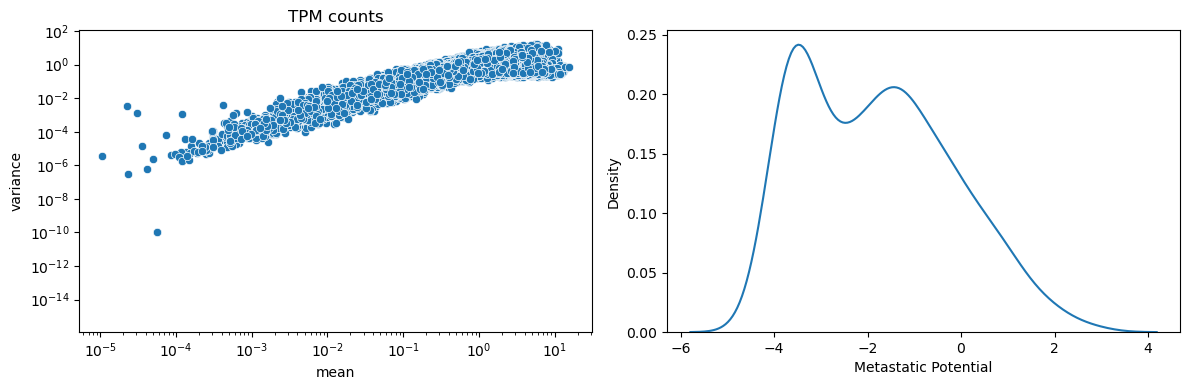

In [7]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 4))
ax = ax.flatten()

# subplot 1
i = 0
sns.scatterplot(data = stats_novst, x = 'mean', y = 'variance', ax = ax[i])
ax[i].set_xscale('log')
ax[i].set_yscale('log')
ax[i].set_title('TPM counts')

# subplot 2
# i += 1
# sns.scatterplot(data = stats, x = 'mean', y = 'variance', ax = ax[i])
# ax[i].set_xscale('symlog')
# ax[i].set_yscale('log')
# ax[i].set_title('VST counts')
# ax[i].yaxis.set_major_locator(ticker.FixedLocator([0.01, 0.1, 1, 10]))
# ax[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))

# # subplot 3
# i+=1
# sns.kdeplot(nexpr.sum().tolist(), ax = ax[i])
# ax[i].set_xlabel('Sample-wise TPM Count Sum')
# # ax[i].set_xscale('log')

# subplot 4
i+=1
sns.kdeplot(data=mp, x='mean', ax = ax[i])
ax[i].set_xlabel('Metastatic Potential')

fig.tight_layout()
;

We do not filter out low - mean genes. This would result in a different set of features for each train-test split. Instead, we rely on feature selection + model regularization to appropriately incorporate features. Below is code confirming that 1) low expression genes do not have a strong influence on the consensus joint model fit from Notebook C (they are lowly ranked by abs SVR coefficient), and 2) expression mean does not have a strong influence on model rank by spearman correlation. These results confirm that the lack of this filtering step does not alter our overall model fits or prediction results. 

In [6]:
mp.to_csv(os.path.join(data_path, 'processed', 'metastatic_potential.csv'))
expr.to_csv(os.path.join(data_path, 'processed', 'expr.csv'))